# Demos: Lecture 19

In [3]:
import pennylane as qml
from pennylane import numpy as np
from itertools import chain

from lecture19_helpers import *

## Demo 1: QAOA from scratch

$$
\hat{H}_c = \gamma \sum_{ij \in E} (Z_i + Z_j + Z_i Z_j) - 2 \lambda \sum_{i \in V} Z_i
$$

$$
\hat{H}_m = \sum_{i\in V} X_i
$$

In [4]:
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0), (1, 4)]

In [10]:
edge_terms = [[qml.PauliZ(i), qml.PauliZ(j), qml.PauliZ(i) @ qml.PauliZ(j)] for (i, j) in edges]
edge_terms = list(chain(*edge_terms))
edge_coeffs = [1] * len(edge_terms)

vertex_terms = [qml.PauliZ(i) for i in range(5)]
vertex_coeffs = [-2] * len(vertex_terms)

edge_h = qml.Hamiltonian(edge_coeffs, edge_terms)
vertex_h = qml.Hamiltonian(vertex_coeffs, vertex_terms)

cost_h = edge_h + vertex_h

In [11]:
mixer_terms = [qml.PauliX(i) for i in range(5)]
mixer_coeffs = [1] * len(mixer_terms)
mixer_h = qml.Hamiltonian(mixer_coeffs, mixer_terms)

In [12]:
dev = qml.device('default.qubit', wires=5)

@qml.qnode(dev)
def qaoa_circuit(beta_c, alpha_m):
    # Initalize
    for wire in range(5):
        qml.Hadamard(wires=wire)
    
    # Apply alternating layers
    for idx in range(len(beta_c)):
        qml.ApproxTimeEvolution(cost_h, beta_c[idx], 1)
        qml.ApproxTimeEvolution(mixer_h, alpha_m[idx], 1)
    
    # Return expval of cost H
    return qml.expval(cost_h)

In [13]:
n_layers = 7
beta_c = np.random.normal(size=n_layers)
alpha_m = np.random.normal(size=n_layers)

In [14]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)

for _ in range(100):
    (beta_c, alpha_m) = opt.step(qaoa_circuit, beta_c, alpha_m)

In [15]:
@qml.qnode(dev)
def qaoa_probs(beta_c, alpha_m):
    # Initalize
    for wire in range(5):
        qml.Hadamard(wires=wire)
    
    # Apply alternating layers
    for idx in range(len(beta_c)):
        qml.ApproxTimeEvolution(cost_h, beta_c[idx], 1)
        qml.ApproxTimeEvolution(mixer_h, alpha_m[idx], 1)
    
    # Return expval of cost H
    return qml.probs(wires=range(5))

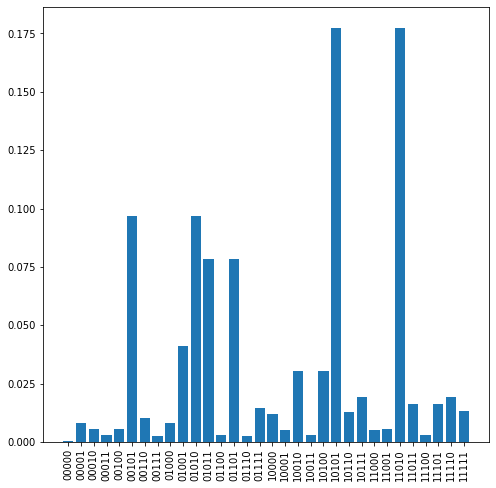

In [16]:
plot_probs(qaoa_probs(beta_c, alpha_m))

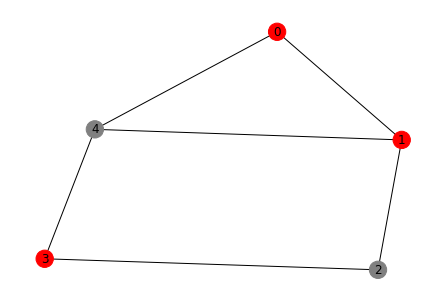

In [19]:
plot_graph(edges, '11010')

## Demo 2: using `qml.qaoa`

In [20]:
graph = nx.Graph(edges)
cost_h, mixer_h = qml.qaoa.min_vertex_cover(graph, constrained=False)

In [23]:
def single_layer(beta_c_single, alpha_m_single):
    qml.qaoa.cost_layer(beta_c_single, cost_h)
    qml.qaoa.mixer_layer(alpha_m_single, mixer_h)

@qml.qnode(dev)
def qaoa_circuit(beta_c, alpha_m):
    for wire in range(5):
        qml.Hadamard(wires=wire)
        
    qml.layer(single_layer, len(beta_c), beta_c, alpha_m)

    return qml.expval(cost_h)

In [24]:
n_layers = 5
beta_c = np.random.normal(size=n_layers)
alpha_m = np.random.normal(size=n_layers)

opt = qml.GradientDescentOptimizer(stepsize=0.01)

for _ in range(100):
    (beta_c, alpha_m) = opt.step(qaoa_circuit, beta_c, alpha_m)            

In [25]:
@qml.qnode(dev)
def qaoa_probs_circuit(beta_c, alpha_m):
    for wire in range(5):
        qml.Hadamard(wires=wire)
        
    qml.layer(single_layer, len(beta_c), beta_c, alpha_m)

    return qml.probs(wires=range(5))

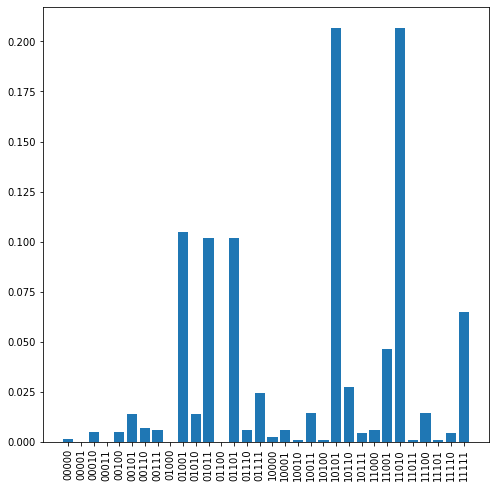

In [26]:
plot_probs(qaoa_probs_circuit(beta_c, alpha_m))

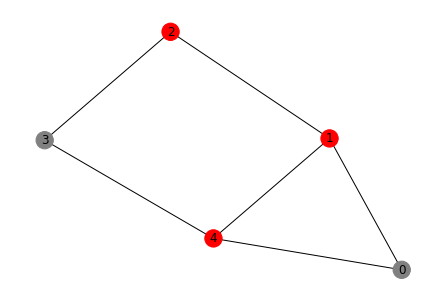

In [27]:
plot_graph(edges, '01101')